In [206]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os, sys

from sklearn.linear_model import LogisticRegression
import csv


In [2]:
root_path = os.getcwd()
data_path = os.path.join(root_path, "Data")

train_path = os.path.join(data_path, "train_set.json")
test_path = os.path.join(data_path, "test_set.json")
documents_path = os.path.join(data_path, "documents.json")

In [3]:
import json

f = open(train_path)
train_set = json.load(f)
f = open(test_path)
test_set = json.load(f)
f = open(documents_path)
documents = json.load(f)

In [4]:
train_df = pd.read_json(train_path)
test_df = pd.read_json(test_path)
documents_df = pd.read_json(documents_path)

In [5]:
train_df.head()

,document,summary,label
0,Two GOP presidential hopefuls - Ted Cruz and B...,Ted Cruz and Ben Carson want the charity to re...,1
1,The Tesla Model S P85D's 'insane mode' may be ...,"latvia-based drive eo has created a vehicle, n...",0
2,MI5 has issued an alert over the threat posed ...,"Alert issued over rogue workers in nuclear , t...",1
3,A new video that shows homeless people reading...,A short film highlights the nasty things peopl...,1
4,Aston Villa may be gearing up for an FA Cup se...,tim sherwood replied to a letter from charlie ...,0


In [6]:
documents_df.head()

,document
0,(CNN) -- Shelling hit areas near two key citie...
1,There aren't many NFL players who influenced t...
10,Work has got under way to repaint the striking...
100,(CNN) -- American Presidents have come and gon...
1000,Jessie Roach is 31 years old and has mental di...


> - **Train set.json**: This file contains 8000 summaries in total with (in the field summary of the json file) their original documents (in the field document of the json file) and labels (in the field label of the json file). The dataset is divided as follows: 4000 reference summaries and 4000 summaries generated from different machine summarisation systems.

> - **Test set.json:** This file contains 3600 summaries in total, divided as follows: 1600 reference summaries and 1600 summaries generated using the same models used in the train set. This dataset is distributed equally between the public and private leaderboards on kaggle.

> - **Documents.json:** This file contains 50000 original documents that could be useful to make the predictions.

In [7]:
documents_df["document"][0]

"(CNN) -- Shelling hit areas near two key cities in eastern Ukraine on Sunday morning, intensifying fears that a ceasefire that took effect less than two days ago may be falling apart.\n\nWhy is the ceasefire under strain?\n\nA variety of fighting factions in the conflict zone -- on both sides -- may not fall directly under a military chain of command. The pro-Russian rebels are mostly volunteer militias; fighting against them on the Ukrainian side are at least some far-right nationalist militias. Controlling these groups is difficult and some may have different aims, including sabotaging the truce.\n\nAt this point it's been nearly impossible to figure out who's doing the firing and why.\n\nThe conditions of the ceasefire agreement don't help either. The conditions are vague and at this point there doesn't seem to be an effective mechanism in place inside the conflict zone to monitor and enforce the agreement.\n\nWhy can't the two sides' leaders control their forces?\n\nIt's unclear i

In [8]:
train_df["document"][0]

"Two GOP presidential hopefuls - Ted Cruz and Ben Carson - want the Clinton Foundation to return every dollar its received from foreign governments since it launched more than a decade ago.\n\nThe bum rush on the non-profit came about after a report cast a new shadow over the charity's fundraising practices while Hillary Clinton served as the United State's chief diplomat.\n\nA Reuters investigation that revealed the Bill, Hillary and Chelsea Clinton Foundation had misreported millions of dollars in donations from foreign nations led the global charity to announce that it would refile more than five years of tax documents.\xa0\n\nScroll down for video\xa0\n\nA Reuters investigation that revealed the Bill, Hillary and Chelsea Clinton Foundation had misreported millions of dollars in donations from foreign nations led the global charity to announce that it would refile more than five years of tax documents - Republicans pounced\n\nThe discovery came as separate financial reviews found th

In [9]:
train_df["summary"][0]

"Ted Cruz and Ben Carson want the charity to return every dollar its received from foreign governments since its launch in 2001 . Bum rush came about after a report cast a new shadow over the charity 's fundraising practices while Hillary Clinton was the country 's chief diplomat . Cruz said : ` Having raised tens of millions of dollars from foreign nations presents a clear conflict of interest for anyone running for President ' Carson said they ` should they definitely give back the money and cease accepting foreign donations , but should also make every effort to find missing documents that would shed light if in fact they are innocent ' Carly Fiorina said , ` It 's the Clinton way : raking in millions from foreign governments behind closed doors while making promises about transparency that they never intended to keep '"

------------------------------------------------------------------------------------

### Data Analysis & Feature Generation

In [27]:
import seaborn as sns
import string
import nltk
import warnings 

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Get the number of dates / entries in each month
train_df.groupby('label')['summary'].count()

label
0    4000
1    4000
Name: summary, dtype: int64

In [29]:
## Character length
train_df['character_cnt'] = train_df['summary'].str.len()
train_df.groupby('label')['character_cnt'].mean()

label
0    304.60550
1    307.99875
Name: character_cnt, dtype: float64

In [31]:
train_df['word_counts'] = train_df['summary'].str.split().str.len()
train_df.groupby('label')['word_counts'].mean()

label
0    54.887
1    56.925
Name: word_counts, dtype: float64

In [32]:
train_df['characters_per_word'] = train_df['character_cnt']/train_df['word_counts']
train_df.groupby('label')['characters_per_word'].mean()

label
0    5.597578
1    5.441352
Name: characters_per_word, dtype: float64

In [33]:
# Special character count
train_df['spl'] = train_df['summary'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))

In [35]:
#Number of numerics
train_df['num'] = train_df['summary'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train_df.groupby('label')['num'].mean()

label
0    0.67025
1    0.80450
Name: num, dtype: float64

In [37]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train_df['processedtext'] = train_df['summary'].str.replace('[^\w\s]','') 
train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#Lines 4 to 6
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

train_df[['character_cnt','word_counts','characters_per_word', 'spl', 'num', 'processedtext']].head()

,character_cnt,word_counts,characters_per_word,spl,num,processedtext
0,833,146,5.705479,0,1,ted cruz ben carson want chariti return everi ...
1,362,65,5.569231,0,3,latviabas drive eo creat vehicl name eo pp03 r...
2,298,54,5.518519,0,1,alert issu rogu worker nuclear transport publi...
3,221,44,5.022727,0,0,a short film highlight nasti thing peopl say h...
4,262,48,5.458333,0,0,tim sherwood repli letter charli pye tuesday p...


In [43]:
def extend_features(train_df, stop = stop, stemmer = stemmer):
    train_df['character_cnt'] = train_df['summary'].str.len()
    train_df['word_counts'] = train_df['summary'].str.split().str.len()
    train_df['characters_per_word'] = train_df['character_cnt']/train_df['word_counts']
    train_df['spl'] = train_df['summary'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
    train_df['num'] = train_df['summary'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    train_df['processedtext'] = train_df['summary'].str.replace('[^\w\s]','') 
    train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join(x.lower() for x in x.split()))

    train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
    
    return train_df

In [62]:
## Term Frequency-Inverse Document Frequency (TF-IDF) Vector

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))

dat_tfIdf = tfidf.fit_transform(train_df['processedtext'])
dat_tfIdf

<8000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 114401 stored elements in Compressed Sparse Row format>

In [63]:
training_labels = train_df["label"]
training_df = train_df.drop(["summary", "document", "label", "processedtext"], axis = 1)

In [64]:
td_df = pd.DataFrame(dat_tfIdf.toarray())
training_df = pd.concat([training_df, td_df], axis=1)

In [65]:
training_df

,character_cnt,word_counts,characters_per_word,spl,num,0,1,2,3,4,...,990,991,992,993,994,995,996,997,998,999
0,833,146,5.705479,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,362,65,5.569231,0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,298,54,5.518519,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,221,44,5.022727,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,262,48,5.458333,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,137,24,5.708333,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.177304,0.0,0.0,0.0,0.0
7996,573,105,5.457143,0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7997,86,19,4.526316,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7998,349,70,4.985714,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [66]:
## Applying LogisitcRegression

clf = LogisticRegression()
clf.fit(training_df, training_labels)

C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [68]:
testing_df = extend_features(test_df, stop = stop, stemmer = stemmer)

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english', ngram_range=(1,1))
test_tfIdf = tfidf.fit_transform(testing_df['processedtext'])

testing_df = testing_df.drop(["summary", "document", "processedtext"], axis = 1)
test_tfIdf

<3200x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 48298 stored elements in Compressed Sparse Row format>

In [69]:
td_df = pd.DataFrame(test_tfIdf.toarray())
testing_df = pd.concat([testing_df, td_df], axis=1)

In [70]:
predictions = clf.predict(testing_df)

In [71]:
# Write predictions to a file
with open("submission2_tfid1000.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(predictions):
        csv_out.writerow([i, row])

In [72]:
## Bag-of-words Vector
from sklearn.feature_extraction.text import CountVectorizer

bag_words = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
dat_BOW = bag_words.fit_transform(train_df['processedtext'])
dat_BOW

<8000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 133155 stored elements in Compressed Sparse Row format>

In [73]:
td_df = pd.DataFrame(dat_BOW.toarray())
training_df = pd.concat([training_df, td_df], axis=1)

In [74]:
## Applying LogisitcRegression
clf = LogisticRegression()
clf.fit(training_df, training_labels)

C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [75]:
bag_words = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
dat_BOW = bag_words.fit_transform(test_df['processedtext'])

In [76]:
td_df = pd.DataFrame(dat_BOW.toarray())
testing_df = pd.concat([testing_df, td_df], axis=1)

In [78]:
predictions = clf.predict(testing_df)

# Write predictions to a file
with open("submission2_BOW.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(predictions):
        csv_out.writerow([i, row])

--------------------------------------------------------------------------------------------------------

### BagOfWords

In [ ]:
!pip install transformers

In [ ]:
!pip install lime

In [15]:
!pip install gensim

In [17]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api


In [21]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return : cleaned text
    '''
    
    ## clean (convert to lowercase and remove punctuations and    characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [23]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [24]:
train_df["text_clean"] = train_df["summary"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
train_df.head()

,document,summary,label,text_clean
0,Two GOP presidential hopefuls - Ted Cruz and B...,Ted Cruz and Ben Carson want the charity to re...,1,ted cruz ben carson want charity return every ...
1,The Tesla Model S P85D's 'insane mode' may be ...,"latvia-based drive eo has created a vehicle, n...",0,latviabased drive eo created vehicle named eo ...
2,MI5 has issued an alert over the threat posed ...,"Alert issued over rogue workers in nuclear , t...",1,alert issued rogue worker nuclear transport pu...
3,A new video that shows homeless people reading...,A short film highlights the nasty things peopl...,1,short film highlight nasty thing people say ho...
4,Aston Villa may be gearing up for an FA Cup se...,tim sherwood replied to a letter from charlie ...,0,tim sherwood replied letter charlie pye tuesda...


**Bag-of-Words:**
The Bag-of-Words model is simple: it builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. To put it another way, each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (a “bag of words”).

In [25]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

corpus = train_df["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [29]:
len(list(dic_vocabulary.keys()))

10000

Text(0.5, 1.0, 'Sparse Matrix Sample')

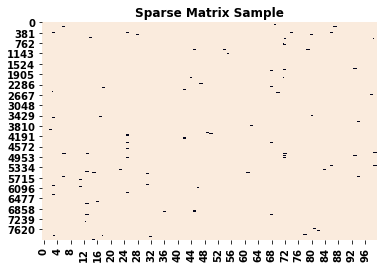

In [27]:
sns.heatmap(X_train.todense()[:,np.random.randint(0, X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [31]:
dic_vocabulary["government"]

4000

In order to drop some columns and reduce the matrix dimensionality, we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:

>- 1- Treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);

>- 2- Perform a Chi-Square test to determine whether a feature and the (binary) target are independent;

>- 3- Keep only the features with a certain p-value from the Chi-Square test.

In [33]:
train_df

<8000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 220180 stored elements in Compressed Sparse Row format>

In [38]:
from sklearn import feature_selection

y = train_df["label"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()

In [39]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
print(" ")

# 0:
  . selected features: 4
  . top features: read,nt,click,click latest
# 1:
  . selected features: 4
  . top features: read,nt,click,click latest
 


In [40]:
dtf_features

,feature,score,y
7276,read,0.986105,0
6259,nt,0.983142,0
2025,click,0.958277,0
2026,click latest,0.950744,0
7276,read,0.986105,1
6259,nt,0.983142,1
2025,click,0.958277,1
2026,click latest,0.950744,1


In [41]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

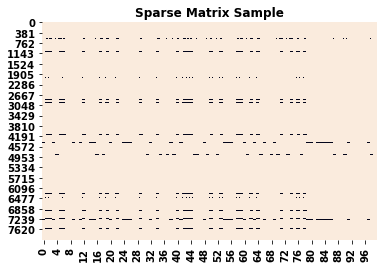

In [44]:
sns.heatmap(X_train.todense()[:,np.random.randint(0, X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

It’s time to train a machine learning model and test it. I recommend using a Naive Bayes algorithm: a probabilistic classifier that makes use of Bayes’ Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

In [49]:
X_train.toarray().shape, y.shape

((8000, 4), (8000,))

In [50]:
classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y)

MultinomialNB()

In [51]:
from sklearn.metrics import accuracy_score

preds = model["classifier"].predict(X_train)
score_train = accuracy_score(y, preds)
print("\t\t Train accuracy score: ", score_train)

		 Train accuracy score:  0.5145


In [ ]:
## test
X_test = test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Word2Vec

In [52]:
nlp_embds = gensim_api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [139]:
corpus = train_df["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1])
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

In [140]:
lst_corpus

[['ted',
  'cruz',
  'ben',
  'carson',
  'want',
  'charity',
  'return',
  'every',
  'dollar',
  'received',
  'foreign',
  'government',
  'since',
  'launch',
  '2001',
  'bum',
  'rush',
  'came',
  'report',
  'cast',
  'new',
  'shadow',
  'charity',
  'fundraising',
  'practice',
  'hillary',
  'clinton',
  'country',
  'chief',
  'diplomat',
  'cruz',
  'said',
  'raised',
  'ten',
  'million',
  'dollar',
  'foreign',
  'nation',
  'present',
  'clear',
  'conflict',
  'interest',
  'anyone',
  'running',
  'president',
  'carson',
  'said',
  'definitely',
  'give',
  'back',
  'money',
  'cease',
  'accepting',
  'foreign',
  'donation',
  'also',
  'make',
  'every',
  'effort',
  'find',
  'missing',
  'document',
  'would',
  'shed',
  'light',
  'fact',
  'innocent',
  'carly',
  'fiorina',
  'said',
  'clinton',
  'way',
  'raking',
  'million',
  'foreign',
  'government',
  'behind',
  'closed',
  'door',
  'making',
  'promise',
  'transparency',
  'never',
  'inte

In [142]:
## Detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ",
                                                 min_count=5, threshold=10)
#bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus])
#trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [143]:
len(lst_corpus)

8000

When fitting the Word2Vec, you need to specify:
>- The target size of the word vectors, I’ll use 300;
>- The window, or the maximum distance between the current and predicted word within a sentence, I’ll use the mean length of text in the corpus;
>- The training algorithm, I’ll use skip-grams (sg=1) as in general it has better results.

In [144]:
## fit w2v
nlp_word2vec = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300, window=8, min_count=1, sg=1, workers=4)

In [145]:
nlp_word2vec.save("word2vec.model")

In [146]:
nlp_word2vec.wv

C:\Users\Imadeddine\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


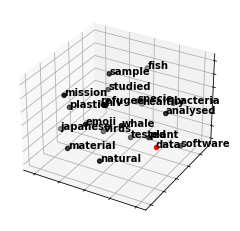

In [147]:
word = "data"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in nlp_word2vec.wv.most_similar(word, topn=20)]
X = nlp_word2vec.wv[tot_words]

## PCA to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")

ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [148]:
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [149]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=100, padding="post", truncating="post")

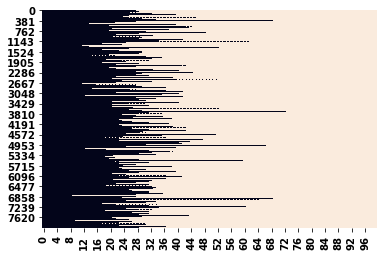

In [150]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Every text in the corpus is now an id sequence with length 100. For instance, if a text had 10 tokens in it, then the sequence is composed of 10 ids + 90 0s, which is the padding element (while the id for word not in the vocabulary is 1). Let’s print how a text from the train set has been transformed into a sequence with the padding and the vocabulary.

In [151]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(train_df["text_clean"].iloc[i].split())
print("from: ", train_df["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", train_df["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[train_df["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  ted cruz ben carson want charity return every dollar received foreign government since launch 2001 bum rush came report cast new shadow charity fundraising practice hillary clinton country chief diplomat cruz said raised ten million dollar foreign nation present clear conflict interest anyone running president carson said definitely give back money cease accepting foreign donation also make every effort find missing document would shed light fact innocent carly fiorina said clinton way raking million foreign government behind closed door making promise transparency never intended keep | len: 85
to:  [ 3530  3131  1409  5778   128   786   134   415  2465   423   705   209
    36   867  4365 15989  4732   234   218  2552     5  4032   786  4366
  1627  1016   383   169   631  6522  3131     2  1151   539    81  2465
   705   649  2009   435  2466   937  1152   886   166  5778     2  3751
   307    32   180 11411  4033   705  2082    10    76   415  1212   342
   357  1374    22  4

In [153]:
test_df

,document,summary
0,It's that time of the season when Premier Leag...,Premier League footballers are voting for PFA ...
1,"A Florida woman, 21, has been charged with dri...",Mackenzi Sue-Rose Miller allegedly struck and ...
2,Tara Reid's boyfriend was reportedly fired fro...,"Aaron Kaufman , former chief technology office..."
3,Manchester United midfielder Marouane Fellaini...,Thibaut Courtois hopes Chelsea can keep Maroua...
4,"A dominatrix who claims she shared a 'hot, dee...","Dominatrix claims she shared a ` hot , deep ki..."
...,...,...
3195,Castleford's blockbusting Australian winger Ju...,Castleford Tigers defeated Hull KR 25-4 in the...
3196,Gareth Bale was verbally abused by supporters ...,Atletico Madrid 0-0 Real Madrid : Click here f...
3197,An Iditarod sled dog who escaped from handlers...,"Runaway Alaskan Husky , Sarabi , escaped on Ma..."
3198,Adam Johnson has been charged with three offen...,Adam Johnson charged with three counts of sexu...


In [156]:
### Apply same process for testing data

test_df["text_clean"] = test_df["summary"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

corpus = test_df["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)

In [157]:
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=100,
             padding="post", truncating="post")

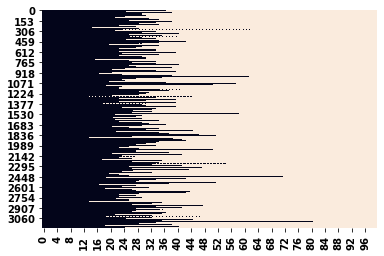

In [198]:
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

We’ve got our X_train and X_test, now we need to create the matrix of embedding that will be used as a weight matrix in the neural network classifier.

In [159]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [161]:
embeddings.shape            # (Length of vocabulary extracted from the corpus x Vector size)

(26956, 300)

In [160]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 1828 |idx
embeddings[idx]: (300,) |vector


It’s finally time to build a deep learning model. I’m going to use the embedding matrix in the first Embedding layer of the neural network that I will build and train to classify the news. Each id in the input sequence will be used as the index to access the embedding matrix. The output of this Embedding layer will be a 2D matrix with a word vector for each word id in the input sequence (Sequence length x Vector size).

In [182]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(100,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=100, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=100)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=100, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=100, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     8086800     input_4[0][0]                    
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 300, 100)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 300, 100)     10100       permute_3[0][0]                  
____________________________________________________________________________________________

In [183]:
y_train = train_df["label"]

In [184]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=1, 
                     validation_split=0.3)

Epoch 1/10
22/22 [==============================] - 64s 3s/step - loss: 0.6932 - accuracy: 0.4918 - val_loss: 0.6931 - val_accuracy: 0.5167
Epoch 2/10
22/22 [==============================] - 56s 3s/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6934 - val_accuracy: 0.4833
Epoch 3/10
22/22 [==============================] - 57s 3s/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6934 - val_accuracy: 0.4833
Epoch 4/10
22/22 [==============================] - 59s 3s/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6936 - val_accuracy: 0.4833
Epoch 5/10
22/22 [==============================] - 61s 3s/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6936 - val_accuracy: 0.4833
Epoch 6/10
22/22 [==============================] - 61s 3s/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6936 - val_accuracy: 0.4833
Epoch 7/10
22/22 [==============================] - 61s 3s/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6938 - val_accuracy: 0.4833
Epoch 8/10
22/22 [==

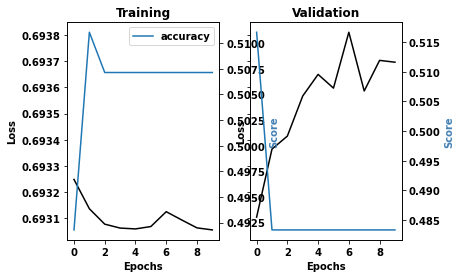

In [188]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [189]:
## test
predicted_prob = model.predict(X_train)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [195]:
predicted_prob.shape, y_train.shape

((8000, 2), (8000,))

Accuracy: 0.5
Auc: 0.5
Detail:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4000
           1       0.00      0.00      0.00      4000

    accuracy                           0.50      8000
   macro avg       0.25      0.50      0.33      8000
weighted avg       0.25      0.50      0.33      8000



C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


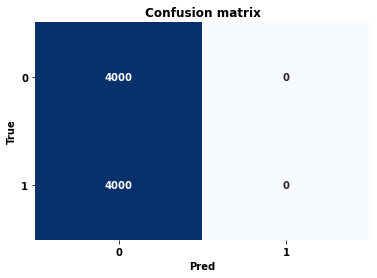

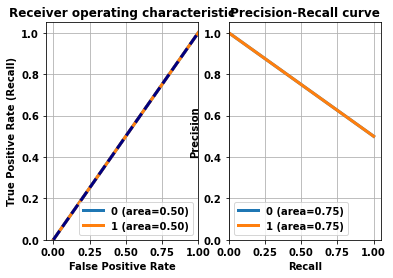

In [196]:
from sklearn import metrics

classes = np.unique(y_train)
y_test_array = pd.get_dummies(y_train, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_train, predicted)
auc = metrics.roc_auc_score(y_train, predicted, 
                            multi_class="ovo")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_train, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_train, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [197]:
model.save("Word2Vec_Train_10epochs")

C:\Users\Imadeddine\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: Word2Vec_Train_10epochs\assets


INFO:tensorflow:Assets written to: Word2Vec_Train_10epochs\assets


In [207]:
## Applying LogisitcRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [208]:
predictions = clf.predict(X_test)

In [209]:
predictions

array([1, 0, 0, ..., 0, 1, 1])

In [210]:
# Write predictions to a file
with open("submission_Word2Vec_LR.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(predictions):
        csv_out.writerow([i, row])